In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy
import netket as nk
import jax
import jax.numpy as jnp
import netket.nn as nknn
from jax import grad, jit, vmap, vjp 
from jax import random
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, eigvalsh
from sympy.combinatorics import Permutation as Perm
from sympy.interactive import init_printing
import json
import networkx as nx 
from jax import random
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import netket.nn as nknn
import flax.linen as nn
import time 
import json 



In [ ]:
'''
The 2 x 4 square lattices with frustration J2 = 0, J2 = 0.5 J2 = 0.8
'''



In [14]:
graph = nk.graph.Grid(extent= [3,4], pbc=False)
hi = nk.hilbert.Spin(s=float(0.5), total_sz=float(0.0), N=graph.n_nodes)
ha = nk.operator.Heisenberg(hilbert=hi, graph=graph)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy1 = evals[0]
print('The exact ground-state energy from computational basis J2=0.5 =',exact_gs_energy1/float(4)) 

The exact ground-state energy from computational basis J2=0.5 = -6.691680193514958


## J2 = 0.5 Case 

[1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1]
The exact ground-state energy from computational basis J2=0.5 = -3.5967417122300613


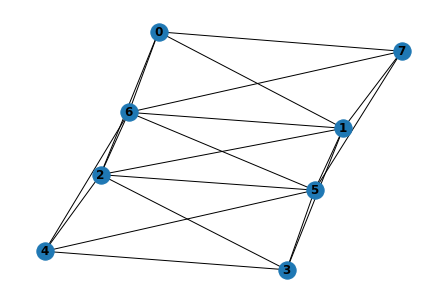

In [4]:
J = [1, 0.5]
# graph = nk.graph.Grid(extent= [2,4], pbc=False)
# edges = graph.edges
# nx.draw(graph.to_networkx(), with_labels=True, font_weight='bold')
edge_colors = [[0, 1, 1], [0, 7, 1], [0, 2,2], 
               [0, 6, 2], [1,2,1], [1,6,1], [1,7,2], [1,3,2],
              [1,5,2], [2,3,1],[2,5,1], [2,6,2], [2,4,2], [3,4,1], [3,5,2], [4,5,1]
             ,[4,6,2], [5,6,1], [5,7,2], [6,7,1]]

#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (J[0] * exchange).tolist(),
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

# graph = nk.graph.Grid(extent= [2,4], pbc=False, edge_colors = edge_colors)
g = nk.graph.Graph(edges=edge_colors)
nx.draw(g.to_networkx(), with_labels=True, font_weight='bold')
hi = nk.hilbert.Spin(s=float(0.5), total_sz=float(0.0), N=g.n_nodes)
print(g.edge_colors)
ha = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy1 = evals[0]
print('The exact ground-state energy from computational basis J2=0.5 =',exact_gs_energy1/float(4)) 

### Using RBM model 

In [10]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=float(1e-3))

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=float(0.1))

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=int(400))

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=int(600))
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

# import the data from log file
data=json.load(open("RBM.log"))

# Extract the relevant information
iters_RBM = data["Energy"]["iters"]
energy_RBM = data["Energy"]["Mean"]

100%|██████████| 600/600 [00:06<00:00, 87.28it/s, Energy=-3.077 ± 0.098 [σ²=3.879, R̂=1.0648]] 

### RBM calculation
Has 80 parameters
The RBM calculation took 6.893106937408447 seconds


### Using GCNN with spatial symmetries  

In [12]:
symmetries = g.automorphisms()
#Feature dimensions of hidden layers, from first to last
feature_dims = (16,16, 16, 16)

#Number of layers
num_layers = 4

#Define the GCNN
ma = nk.models.GCNN(symmetries = symmetries, layers = num_layers, features = feature_dims)

#Metropois-Hastings with two spins flipped that are at most second nearest neighbors
sa = nk.sampler.MetropolisExchange(hilbert = hi, graph=g, d_max=2)

#Stochaistic reconfiguration
op = nk.optimizer.Sgd(learning_rate=1e-3)
sr = nk.optimizer.SR(diag_shift=0.01)

#Define a variational state so we can keep the parameters if we like
vstate = nk.variational.MCState(sampler=sa, model=ma, n_samples=400)

#Define a driver that performs VMC
gs = nk.driver.VMC(ha, op, sr=sr, variational_state=vstate)
#Run the optimization
gs.run(n_iter=600, out='out')
#Get data from log and
energy_gcnn = []
data_gcnn=json.load(open("out.log"))
for en in data_gcnn["Energy"]["Mean"]:
    energy_gcnn.append(en)



/Users/liuping/opt/anaconda3/envs/sage/lib/python3.9/site-packages/netket/variational.py:29: FutureWarning: The `netket.variational` module is deprecated. Use `netket.vqs` instead.
To fix this warning, change `netket.variational.MCState to `netket.vqs.MCState`.
  _warn_deprecation(
/Users/liuping/opt/anaconda3/envs/sage/lib/python3.9/site-packages/netket/driver/vmc.py:86: FutureWarning: The `sr` keyword argument is deprecated in favour of `preconditioner`.Please update your code to `VMC(.., precondioner=your_sr)`
  warn_deprecation(
100%|██████████| 600/600 [01:12<00:00,  8.32it/s, Energy=-2.98630 ± 0.00013 [σ²=0.00001, R̂=1.0280]]


### Plot Data 

In [7]:
import pandas as pd

df = pd.read_csv('../data/CQA_3s_0.5.csv')
CQA_energy1 = df.to_numpy()[:,1]
CQA_iters1 = np.multiply(df.to_numpy()[:,0], 5.0)



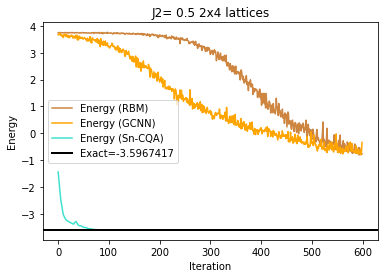

<Figure size 432x288 with 0 Axes>

In [11]:
fig, ax1 = plt.subplots()
ax1.plot(iters_RBM, np.divide(energy_RBM,float(4.0)), color='peru', label='Energy (RBM)')
ax1.plot(iters_RBM, np.divide(energy_gcnn,float(4.0)), color='orange', label='Energy (GCNN)')
ax1.plot(CQA_iters1, CQA_energy1, color='turquoise', label='Energy (Sn-CQA)')

ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
# plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=np.divide(exact_gs_energy, float(4.0)), xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact=-3.5967417')
ax1.legend()
plt.title('J2= 0.5 2x4 lattices')
plt.show()
plt.savefig('../data/0.5_3s_plot.png')

In [ ]:
Data1 = dict()
# Data1['GCNN'] = np.divide(energy_gcnn,float(4.0))
Data1['RBM'] = np.divide(energy_RBM,float(4.0))

df1 = pd.DataFrame(Data1)
df1.to_csv('../RBM_3s_J0.5.csv')

## J2 = 0.8 case 

In [ ]:
J = [1, 0.8]
# graph = nk.graph.Grid(extent= [2,4], pbc=False)
# edges = graph.edges
# nx.draw(graph.to_networkx(), with_labels=True, font_weight='bold')
edge_colors = [[0, 1, 1], [0, 7, 1], [0, 2,2], 
               [0, 6, 2], [1,2,1], [1,6,1], [1,7,2], [1,3,2],
              [1,5,2], [2,3,1],[2,5,1], [2,6,2], [2,4,2], [3,4,1], [3,5,2], [4,5,1]
             ,[4,6,2], [5,6,1], [5,7,2], [6,7,1]]

#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (J[0] * exchange).tolist(),
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

# graph = nk.graph.Grid(extent= [2,4], pbc=False, edge_colors = edge_colors)
g = nk.graph.Graph(edges=edge_colors)
nx.draw(g.to_networkx(), with_labels=True, font_weight='bold')
hi = nk.hilbert.Spin(s=float(0.5), total_sz=float(0.0), N=g.n_nodes)
print(g.edge_colors)
ha = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy2 = evals[0]
print('The exact ground-state energy from computational basis J2=0.8 =',exact_gs_energy2/float(4)) 

In [ ]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=float(0.05))

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=float(0.1))

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=int(600))

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=int(600))
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

# import the data from log file
data=json.load(open("RBM.log"))

# Extract the relevant information
iters_RBM2 = data["Energy"]["iters"]
energy_RBM2 = data["Energy"]["Mean"]



In [ ]:
symmetries = g.automorphisms()
#Feature dimensions of hidden layers, from first to last
feature_dims = (8,8,8,8,8,8,8,8)

#Number of layers
num_layers = 8

#Define the GCNN
ma = nk.models.GCNN(symmetries = symmetries, layers = num_layers, features = feature_dims)

#Metropois-Hastings with two spins flipped that are at most second nearest neighbors
sa = nk.sampler.MetropolisExchange(hilbert = hi, graph=g, d_max=2)

#Stochaistic reconfiguration
op = nk.optimizer.Sgd(learning_rate=1e-2)
sr = nk.optimizer.SR(diag_shift=0.01)

#Define a variational state so we can keep the parameters if we like
vstate = nk.variational.MCState(sampler=sa, model=ma, n_samples=600)

#Define a driver that performs VMC
gs = nk.driver.VMC(ha, op, sr=sr, variational_state=vstate)
#Run the optimization
gs.run(n_iter=600, out='out')
#Get data from log and
energy_gcnn2 = []
data_gcnn2=json.load(open("out.log"))
for en in data_gcnn2["Energy"]["Mean"]:
    energy_gcnn2.append(en)




In [ ]:
df = pd.read_csv('../data/CQA_3s_0.8.csv')
CQA_energy2 = df.to_numpy()[:,1]
CQA_iters2 = np.multiply(df.to_numpy()[:,0], 5.0)

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(iters_RBM2, np.divide(energy_RBM2,float(4.0)), color='peru', label='Energy (RBM)')
ax1.plot(iters_RBM2, np.divide(energy_gcnn2,float(4.0)), color='orange', label='Energy (GCNN)')
ax1.plot(CQA_iters2, CQA_energy2, color='turquoise', label='Energy (Sn-CQA)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax1.set_ylim([-4, 2])
# plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=np.divide(exact_gs_energy2, float(4.0)), xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact=-3.7161769')
ax1.legend()
plt.show()
fig.savefig('../data/0.8_3s_plot.png')

In [ ]:
Data2 = dict()
Data2['GCNN'] = np.divide(energy_gcnn2,float(4.0))
# Data2['RBM'] = np.divide(energy_RBM2,float(4.0))

df2 = pd.DataFrame(Data2)
df2.to_csv('../data/GCNN_3s_J0.8.csv')

In [ ]:
import numpy
import torch
import cnine
import Snob2

rho=sn.irrep(Snob2.IntegerPartition([4,1]))
print(rho,'\n')